#connet colab to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#import dataset from kaggle website
you should upload kagle.json file and you can get it from your kaggle account from Create New Token buttom

In [2]:
# download the required dataset from kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

get api of dataset from kaggle website

In [3]:
!kaggle datasets download -d jimishpatel/fire-detection-dataset

 92% 33.0M/35.7M [00:00<00:00, 109MB/s] 
100% 35.7M/35.7M [00:00<00:00, 98.9MB/s]


unzip dataset to new created folder

In [4]:
!unzip /content/fire-detection-dataset.zip  -d '/content/dataset'

Archive:  /content/fire-detection-dataset.zip
  inflating: /content/dataset/FIRE/FIRE/1 (2).jpg  
  inflating: /content/dataset/FIRE/FIRE/1 (3).jpg  
  inflating: /content/dataset/FIRE/FIRE/1.jpg  
  inflating: /content/dataset/FIRE/FIRE/10 (2).jpg  
  inflating: /content/dataset/FIRE/FIRE/10 (3).jpg  
  inflating: /content/dataset/FIRE/FIRE/10.jpg  
  inflating: /content/dataset/FIRE/FIRE/100.jpg  
  inflating: /content/dataset/FIRE/FIRE/1000.jpg  
  inflating: /content/dataset/FIRE/FIRE/1001.jpg  
  inflating: /content/dataset/FIRE/FIRE/1002.jpg  
  inflating: /content/dataset/FIRE/FIRE/1003.jpg  
  inflating: /content/dataset/FIRE/FIRE/1004.jpg  
  inflating: /content/dataset/FIRE/FIRE/1005.jpg  
  inflating: /content/dataset/FIRE/FIRE/1006.jpg  
  inflating: /content/dataset/FIRE/FIRE/1007.jpg  
  inflating: /content/dataset/FIRE/FIRE/1008.jpg  
  inflating: /content/dataset/FIRE/FIRE/1009.jpg  
  inflating: /content/dataset/FIRE/FIRE/101.jpg  
  inflating: /content/dataset/FIRE/FI











# Model Architecture

#### Importing packages

In [5]:
import os                                     # operating system
import numpy as np                            # linear algebra

[]
from PIL import Image                         # Python image library
import matplotlib.pyplot as plt               # making plots
%matplotlib inline
from IPython.display import display           # displaying ?

import warnings                               # ignoring unnecessary python warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping     # furter train the saved model
from keras import models, layers, optimizers                 # building DNN is keras
from keras.preprocessing.image import ImageDataGenerator     # preparing image data for training
from tensorflow.keras.models import Sequential , load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout ,BatchNormalization, ReLU , GlobalAveragePooling2D

# Preparing the data

#### Calling test and train image directories

These directories were prepared in the other notebook.

In [6]:

base_dir = './dataset'

train_dir = base_dir
train_dir_fire = os.path.join(train_dir, 'FIRE')
train_dir_nofire = os.path.join(train_dir, 'NON FIRE')


#### Data generator & data augmentation

For the large dataset it is not convenient to load all the data into memory. So we use image data generator to load the data from hard disc to memory in small batch. We do the same of the training and test set.

Further, when initiating the image data generator we can do the data augmentation. This is the step to create more data from existing data by transforming the image. This artificially provides more data to train. Here we use rotation, translation, shear, zooming and horizontal flip for data augmentation. Other transformations like verticle flip is not suitable. We only do the data augmentation in the training set and not on the validation and test set.

In [137]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                   validation_split=0.2
                                   )


train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(256, 256),
                                                   batch_size=32,
                                                   class_mode='binary',
                                                    subset='training')

test_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(256, 256),
                                                   batch_size=32,
                                                   class_mode='binary',subset='validation')

Found 3116 images belonging to 2 classes.
Found 778 images belonging to 2 classes.


show sample of dataset

In [8]:
train_generator.class_indices


{'FIRE': 0, 'NON FIRE': 1}

In [9]:
x, y = train_generator.next()

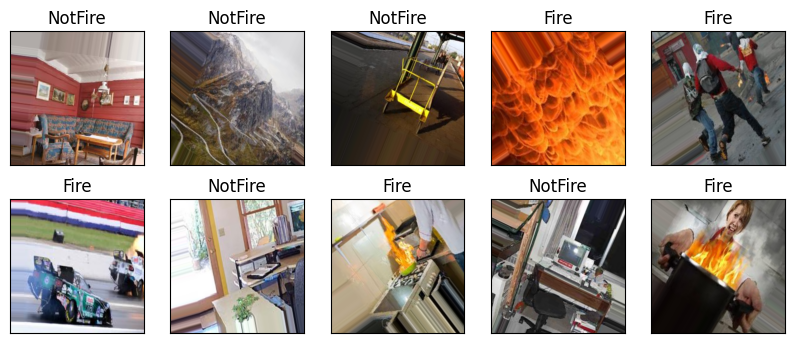

In [10]:
class_name=['Fire', 'NotFire']
n = 10

plt.figure(figsize=(10, 4))
x, y = train_generator.next()
for i in range(n):
  ax = plt.subplot(2, int(n/2), i + 1)
  plt.imshow((x[i]))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title(class_name[int(y[i])])




plt.show()

  # output.clear()

#### Setting up model

We set the model with custom sequentiol model

- Loss: Since this is classification problem and there are two classes, we use the binary cross-entropy as the loss function.

- Optimizer: We use adam optimizer with default learning rate.

- Metrics: In addition to the loss we want to observe the accuracy. We optimize our model based on this metric.

In [124]:

model = Sequential()

model.add(Conv2D(32,(7,7),activation="relu",
                 input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))


model.add(Conv2D(64,(3,3),
                activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

#
model.add(Conv2D(128,(3,3),
                 activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256,(3,3),
                 activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))
#
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))

model.add(Dense(64,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

In [125]:
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

Here is the summary of the model.

In [126]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 250, 250, 32)      4736      
                                                                 
 batch_normalization_1 (Batc  (None, 250, 250, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 125, 125, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                      

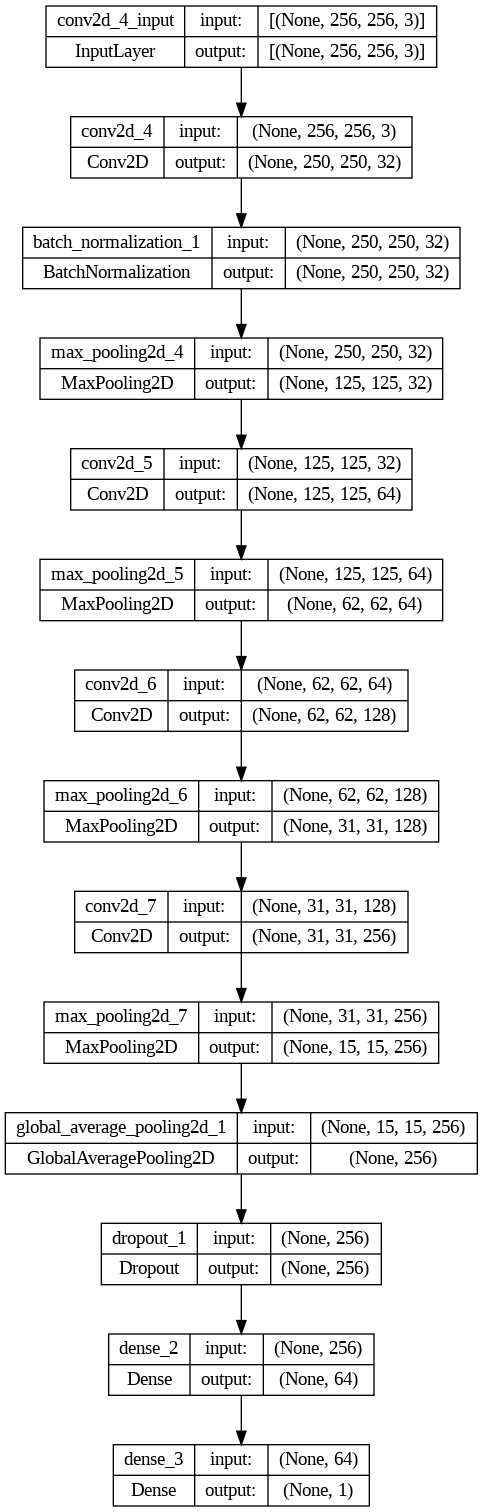

In [127]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Training the model

-We pass the training data from the train_generator. We train for 100 epochs. We pass the validation data from the validation_generator.  We get validation accuracy above to 90% from this depending on earlystop and callbacks to get maximum val accuracy
- we saved the model at desired location on google drive so you can train again and upload trained model any time

In [128]:
file_path = "/content/drive/MyDrive/Models_fire_detection"
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_on_plateau = ReduceLROnPlateau(monitor="loss", mode="min", factor=0.1, patience=5, verbose=1)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
callbacks_list = [ checkpoint, reduce_on_plateau, es]

In [129]:
history = model.fit(train_generator, epochs=100,  callbacks=callbacks_list, verbose=1 ,
                    validation_data=test_generator)

Epoch 1/100
98/98 [==============================] - ETA: 0s - loss: 0.4099 - accuracy: 0.8171
Epoch 1: val_accuracy improved from -inf to 0.83548, saving model to /content/drive/MyDrive/Models_fire_detection


98/98 [==============================] - 67s 647ms/step - loss: 0.4099 - accuracy: 0.8171 - val_loss: 0.4950 - val_accuracy: 0.8355 - lr: 0.0010
Epoch 2/100
98/98 [==============================] - ETA: 0s - loss: 0.3426 - accuracy: 0.8546
Epoch 2: val_accuracy did not improve from 0.83548
98/98 [==============================] - 72s 741ms/step - loss: 0.3426 - accuracy: 0.8546 - val_loss: 0.4220 - val_accuracy: 0.7416 - lr: 0.0010
Epoch 3/100
98/98 [==============================] - ETA: 0s - loss: 0.2823 - accuracy: 0.8813
Epoch 3: val_accuracy improved from 0.83548 to 0.85219, saving model to /content/drive/MyDrive/Models_fire_detection


98/98 [==============================] - 66s 671ms/step - loss: 0.2823 - accuracy: 0.8813 - val_loss: 0.3256 - val_accuracy: 0.8522 - lr: 0.0010
Epoch 4/100
98/98 [==============================] - ETA: 0s - loss: 0.2782 - accuracy: 0.8825
Epoch 4: val_accuracy improved from 0.85219 to 0.87789, saving model to /content/drive/MyDrive/Models_fire_detection


98/98 [==============================] - 66s 675ms/step - loss: 0.2782 - accuracy: 0.8825 - val_loss: 0.3201 - val_accuracy: 0.8779 - lr: 0.0010
Epoch 5/100
98/98 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.8925
Epoch 5: val_accuracy did not improve from 0.87789
98/98 [==============================] - 64s 650ms/step - loss: 0.2736 - accuracy: 0.8925 - val_loss: 0.3093 - val_accuracy: 0.8355 - lr: 0.0010
Epoch 6/100
98/98 [==============================] - ETA: 0s - loss: 0.2453 - accuracy: 0.9082
Epoch 6: val_accuracy did not improve from 0.87789
98/98 [==============================] - 62s 636ms/step - loss: 0.2453 - accuracy: 0.9082 - val_loss: 0.3098 - val_accuracy: 0.8458 - lr: 0.0010
Epoch 7/100
98/98 [==============================] - ETA: 0s - loss: 0.2426 - accuracy: 0.9053
Epoch 7: val_accuracy improved from 0.87789 to 0.90488, saving model to /content/drive/MyDrive/Models_fire_detection


98/98 [==============================] - 64s 650ms/step - loss: 0.2426 - accuracy: 0.9053 - val_loss: 0.2264 - val_accuracy: 0.9049 - lr: 0.0010
Epoch 8/100
98/98 [==============================] - ETA: 0s - loss: 0.2265 - accuracy: 0.9124
Epoch 8: val_accuracy did not improve from 0.90488
98/98 [==============================] - 66s 677ms/step - loss: 0.2265 - accuracy: 0.9124 - val_loss: 0.4978 - val_accuracy: 0.8368 - lr: 0.0010
Epoch 9/100
98/98 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.9188
Epoch 9: val_accuracy did not improve from 0.90488
98/98 [==============================] - 62s 635ms/step - loss: 0.2187 - accuracy: 0.9188 - val_loss: 0.2234 - val_accuracy: 0.9023 - lr: 0.0010
Epoch 10/100
98/98 [==============================] - ETA: 0s - loss: 0.2088 - accuracy: 0.9227
Epoch 10: val_accuracy improved from 0.90488 to 0.90746, saving model to /content/drive/MyDrive/Models_fire_detection


98/98 [==============================] - 64s 653ms/step - loss: 0.2088 - accuracy: 0.9227 - val_loss: 0.2316 - val_accuracy: 0.9075 - lr: 0.0010
Epoch 11/100
98/98 [==============================] - ETA: 0s - loss: 0.2153 - accuracy: 0.9217
Epoch 11: val_accuracy did not improve from 0.90746
98/98 [==============================] - 62s 639ms/step - loss: 0.2153 - accuracy: 0.9217 - val_loss: 0.2928 - val_accuracy: 0.8740 - lr: 0.0010
Epoch 12/100
98/98 [==============================] - ETA: 0s - loss: 0.2004 - accuracy: 0.9239
Epoch 12: val_accuracy did not improve from 0.90746
98/98 [==============================] - 66s 677ms/step - loss: 0.2004 - accuracy: 0.9239 - val_loss: 0.2593 - val_accuracy: 0.8959 - lr: 0.0010
Epoch 13/100
98/98 [==============================] - ETA: 0s - loss: 0.1921 - accuracy: 0.9230
Epoch 13: val_accuracy improved from 0.90746 to 0.91388, saving model to /content/drive/MyDrive/Models_fire_detection


98/98 [==============================] - 72s 735ms/step - loss: 0.1921 - accuracy: 0.9230 - val_loss: 0.2127 - val_accuracy: 0.9139 - lr: 0.0010
Epoch 14/100
98/98 [==============================] - ETA: 0s - loss: 0.1866 - accuracy: 0.9275
Epoch 14: val_accuracy did not improve from 0.91388
98/98 [==============================] - 62s 633ms/step - loss: 0.1866 - accuracy: 0.9275 - val_loss: 0.2557 - val_accuracy: 0.8895 - lr: 0.0010
Epoch 15/100
98/98 [==============================] - ETA: 0s - loss: 0.2072 - accuracy: 0.9191
Epoch 15: val_accuracy did not improve from 0.91388
98/98 [==============================] - 62s 637ms/step - loss: 0.2072 - accuracy: 0.9191 - val_loss: 0.2579 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 16/100
98/98 [==============================] - ETA: 0s - loss: 0.1760 - accuracy: 0.9329
Epoch 16: val_accuracy improved from 0.91388 to 0.92288, saving model to /content/drive/MyDrive/Models_fire_detection


98/98 [==============================] - 75s 765ms/step - loss: 0.1760 - accuracy: 0.9329 - val_loss: 0.2375 - val_accuracy: 0.9229 - lr: 0.0010
Epoch 17/100
98/98 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.9249
Epoch 17: val_accuracy did not improve from 0.92288
98/98 [==============================] - 64s 650ms/step - loss: 0.1879 - accuracy: 0.9249 - val_loss: 0.2829 - val_accuracy: 0.9087 - lr: 0.0010
Epoch 18/100
98/98 [==============================] - ETA: 0s - loss: 0.1739 - accuracy: 0.9326
Epoch 18: val_accuracy did not improve from 0.92288
98/98 [==============================] - 63s 646ms/step - loss: 0.1739 - accuracy: 0.9326 - val_loss: 0.2233 - val_accuracy: 0.9203 - lr: 0.0010
Epoch 19/100
98/98 [==============================] - ETA: 0s - loss: 0.1847 - accuracy: 0.9297
Epoch 19: val_accuracy did not improve from 0.92288
98/98 [==============================] - 62s 631ms/step - loss: 0.1847 - accuracy: 0.9297 - val_loss: 0.2644 - val_accura

98/98 [==============================] - 73s 750ms/step - loss: 0.1581 - accuracy: 0.9387 - val_loss: 0.1942 - val_accuracy: 0.9370 - lr: 0.0010
Epoch 25/100
98/98 [==============================] - ETA: 0s - loss: 0.1569 - accuracy: 0.9429
Epoch 25: val_accuracy did not improve from 0.93702
98/98 [==============================] - 66s 670ms/step - loss: 0.1569 - accuracy: 0.9429 - val_loss: 0.2337 - val_accuracy: 0.8959 - lr: 0.0010
Epoch 26/100
98/98 [==============================] - ETA: 0s - loss: 0.1493 - accuracy: 0.9422
Epoch 26: val_accuracy did not improve from 0.93702
98/98 [==============================] - 62s 636ms/step - loss: 0.1493 - accuracy: 0.9422 - val_loss: 0.1929 - val_accuracy: 0.9332 - lr: 0.0010
Epoch 27/100
98/98 [==============================] - ETA: 0s - loss: 0.1655 - accuracy: 0.9352
Epoch 27: val_accuracy did not improve from 0.93702
98/98 [==============================] - 71s 727ms/step - loss: 0.1655 - accuracy: 0.9352 - val_loss: 0.3060 - val_accura

Saving the model for the future use.

In [160]:
model=load_model('/content/drive/MyDrive/Models_fire_detection')

In [17]:
model.save('/content/drive/MyDrive/fire_detection94.h5')

#### Visualization of the learning

Training gives four sets of values in each eopch

- Training accuracy
- Validation accuracy
- Training loss
- Validation loss

#### Function to make plot

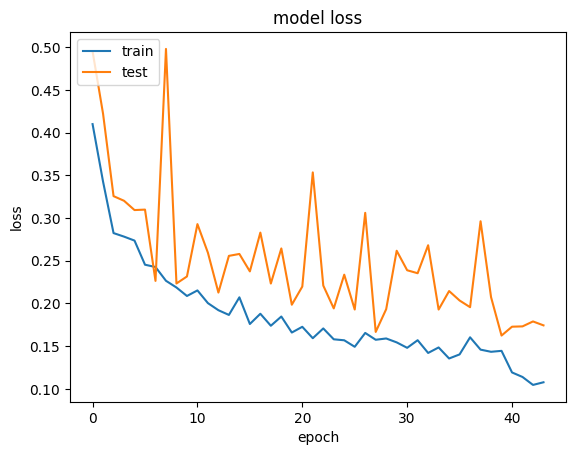

In [130]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

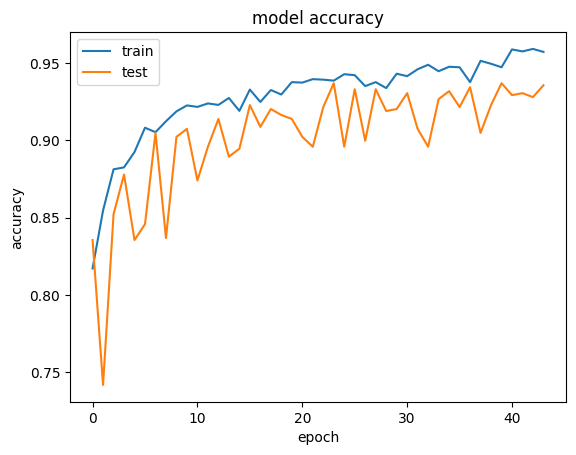

In [131]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Error Analysis

In this section we analyze the error of the model, i.e. mis-classified images. We first see few examples of the correctly classified images. Then we visualize the confusion matrix. And finally, we see separately fire images classified as non-fire and non-fire images classified as fire.  

In [141]:
# Loading the saved model
model = load_model('/content/drive/MyDrive/fire_detection94.h5')

In [142]:
model.evaluate(test_generator,verbose=2)

25/25 - 11s - loss: 0.1425 - accuracy: 0.9473 - 11s/epoch - 452ms/step


[0.142465278506279, 0.9473007917404175]

#### Getting the labels and predictions

In [161]:
# taking first batch from the generator
img, label = test_generator[0]

# Predicting the images from the first batch
pred = np.round(model.predict(img)).flatten()

1/1 [==============================] - 0s 139ms/step


In [162]:
len(img)

32

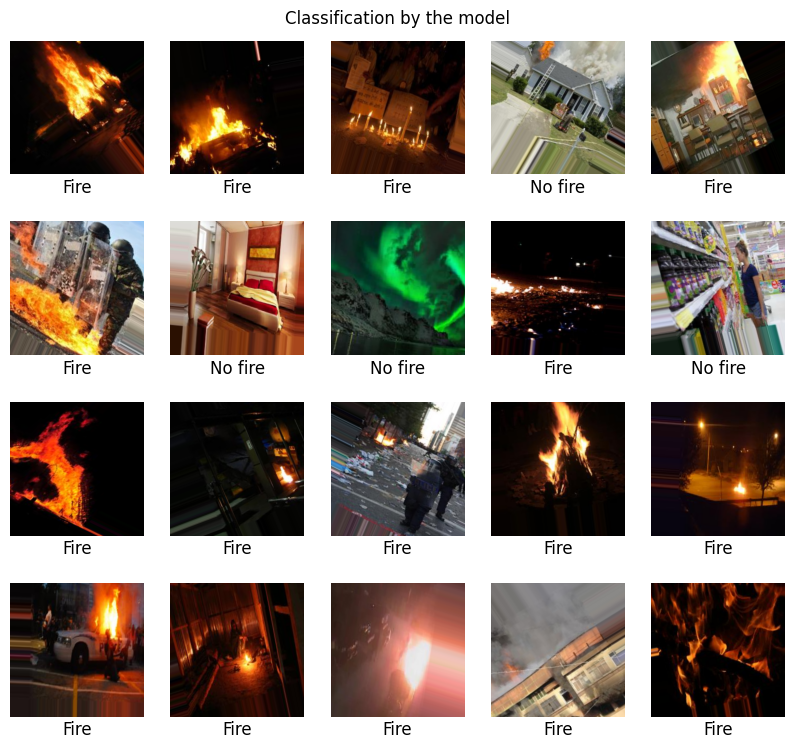

In [163]:
# Numeric to semantic labels
label_dict = {1.0: 'No fire', 0.0: 'Fire'}

# Generating collage of plots
fig = plt.figure(figsize=(10, 9))
plt.title('Classification by the model')
plt.axis('off')

for i, img_i in enumerate(img[:20]):
    ax = fig.add_subplot(4, 5, i+1)
    plt.axis('off')
    plt.title(label_dict[pred[i]], y=-0.2)
    ax.imshow(img_i)

#### Extracting misclassified images

In [164]:
test_sample=len(test_generator)
print(test_sample)

25


In [165]:
# Lists for missed fire images and missed non-fire images
msd_fire = []
msd_nofire = []

# Iterating through all the batches
for j in range(test_sample):
    img, label = test_generator[j]
    pred = np.round(model.predict(img)).flatten()
    bool_list = label == pred

    # bool_list is False when there is misclassification
    for i, e in enumerate(bool_list):
        if e == False:

            # separating labels (fire and non-fire)
            if label[i] == 0:
                msd_fire.append(img[i])
            else:
                msd_nofire.append(img[i])

1/1 [==============================] - 0s 106ms/step


## metrices

In [166]:
#presition
import sklearn.metrics
precision = sklearn.metrics.precision_score(label, pred)
print('precision=', precision)

precision= 0.6666666666666666


In [167]:
# recall

recall = sklearn.metrics.recall_score(label, pred, pos_label=1.0)
print('recall=',recall )

recall= 1.0


In [168]:
# f1 score
fmeasure1 = sklearn.metrics.f1_score(label, pred, average="macro")
print('fmeasure1=', fmeasure1)

fmeasure1= 0.8666666666666667


#### Confusion matrix

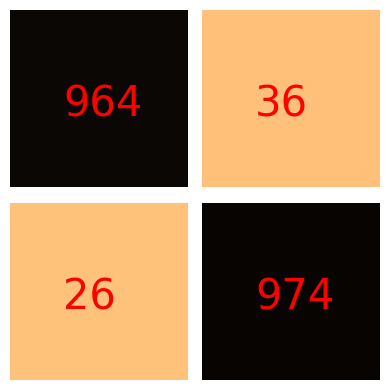

In [169]:
# total number of sample in train set in each class
n_class = 1000

# number of misclassified fire and non-fire images
nm_fire, nm_nofire = len(msd_fire), len(msd_nofire)

# confusion matrix (flattened)
conf_mat = [n_class-nm_fire, nm_fire, nm_nofire, n_class-nm_nofire]

# visualization of confusion matrix
fig = plt.figure(figsize=(4, 4))
for i, j in enumerate(conf_mat):
    ax = fig.add_subplot(2, 2, i+1)
    ax.imshow([[j]], vmin=0, vmax=1000, cmap='copper_r')
    ax.text(-0.2, 0.1, j, c='r', fontsize=30)
    ax.axis('off')

# bringing blocks tighter
fig.tight_layout()
fig.show()

#### Showing mis-classified fire images

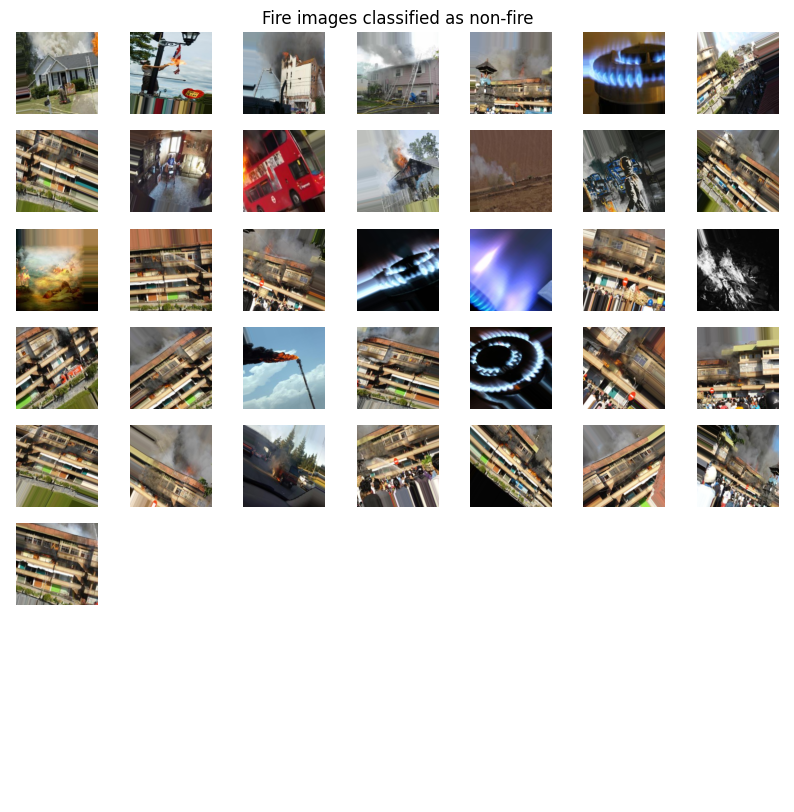

In [176]:
fig = plt.figure(figsize=(10, 10))
plt.title('Fire images classified as non-fire')
plt.axis('off')
for i, img_i in enumerate(msd_fire):
    ax = fig.add_subplot(int(len(msd_fire)/5)+1, int(len(msd_fire)/5), i+1)
    ax.imshow(img_i)
    ax.axis('off')

Some of the misclassified figure have fire but that is too small. So even human observer is easy to confuse with them. Though some of the big explicit fire images are misclassified too. May be that is painting of fire but not the picture. Misclassified fire images are mostly bonfire, stove fire, fire tourch, kitchen fire etc. This is not big surprise because there were not enough fire sample in training set in that categories.  

#### Showing mis-classified non-fire images.

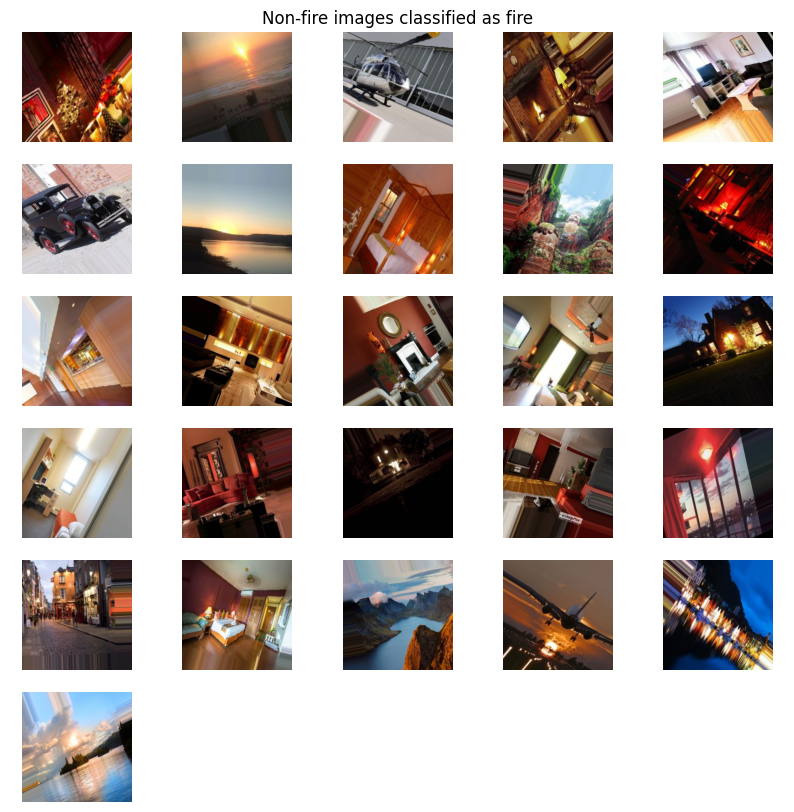

In [175]:
fig = plt.figure(figsize=(10, 10))
plt.title('Non-fire images classified as fire')
plt.axis('off')
for i, img_i in enumerate(msd_nofire):
    ax = fig.add_subplot(int(len(msd_nofire)/5)+1, int(len(msd_nofire)/5),  i+1)
    ax.imshow(img_i)
    ax.axis('off')

Looking at this mis-classified set some of the picture actually seem to have fire. So, the problem is about the mis-labeling. Others don't have fire but have artificial red light or are picture with hue of dawn and dusk almost appearing as fire.

Overall the model has done very good job separating those images with solid 97% accuracy in out of sample images.

# deploy model

In colab it is possible to deploy model using Gradio interface for easy to use model and you can share model with ane one connected to internet and he can make prediction any where

In [54]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.2/294.2 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.3/140.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
 

In [55]:
import gradio as gr

In [109]:
import cv2
SIZE=256
CLASSES=['Fire', 'Not Fire']
def Fire_detection(input):

    #resizing image
    img = cv2.resize(input, (SIZE, SIZE))

    img = img.astype('float32') / 255.0

    predicted = model.predict(np.expand_dims(img,axis=0))
    print(predicted)
    predicted=np.round(predicted).flatten()
    print(predicted)

    return CLASSES[int(predicted)]

In [117]:
title = " Fire detection project "
description = """This project depends on deep learning approach for
             detection whether fire or not fire images.
."""

In [121]:
gr.Interface(fn=Fire_detection,
             inputs=[gr.Image( shape=(SIZE,SIZE), height=300, width=300,label=" image")],
             outputs=[gr.Textbox(show_label=True,  min_width=SIZE,label=" output class")],

              title=title,
             description=description
             ).launch(share=True )

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://2e838e0a8c451cebe9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
